In [1]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

area id_sorted      northing  \
id                                              
nzd0001  3.069093e+06   nzd0001 -4.085604e+06   
nzd0002  1.507931e+06   nzd0002 -4.086100e+06   
nzd0003  2.484730e+06   nzd0003 -4.087232e+06   
nzd0006  9.619509e+05   nzd0004 -4.090732e+06   
nzd0007  3.109433e+06   nzd0005 -4.095516e+06   
...               ...       ...           ...   
nzd0313  2.291974e+07   nzd0558 -4.939929e+06   
nzd0314  3.124363e+07   nzd0559 -4.943102e+06   
nzd0561  8.710035e+05   nzd0560 -5.905869e+06   
nzd0562           NaN      None           NaN   
nzd0563           NaN      None           NaN   

                                                  geometry  
id                                                          
nzd0001  POLYGON ((172.96406 -34.43054, 172.99324 -34.4...  
nzd0002  POLYGON ((172.93456 -34.42857, 172.95856 -34.4...  
nzd0003  POLYGON ((173.0098 -34.42055, 173.00088 -34.44...  
nzd0006  POLYGON ((173.00532 -34.46694, 173.00612 -34.4...  
nzd0007  POLYGON ((172.99847 -34.48102, 173.00081 -34.5...  
...                                                    ...  
nzd0313  POLYGON ((172.89281 -40.50518, 172.73306 -40.5...  
nzd0314  POLYGON ((173.04122 -40.54521, 172.89309 -40.5...  
nzd0561  POLYGON ((168.53017 -46.77383, 168.52 -46.7786...  
nzd0562  POLYGON ((174.90844 -36.8799, 174.90844 -36.86...  
nzd0563  POLYGON ((176.9378 -39.33472, 176.93374 -39.33...  

[562 rows x 4 columns]

1999-08-17 22:10:00+00:00 POINT (172.97690966086745 -34.42150701355086)


<Axes: xlabel='time'>

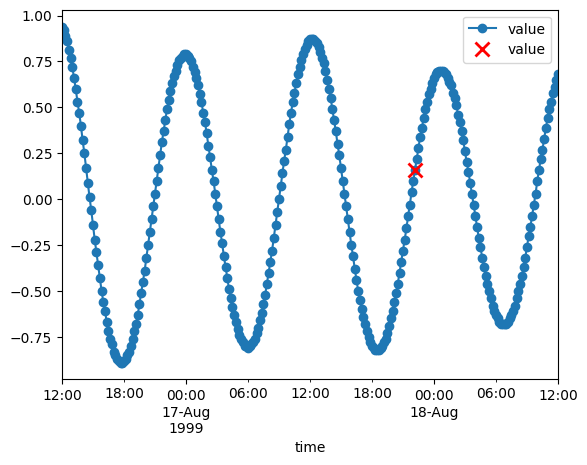

In [3]:
sitename = "nzd0001"
dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
point = poly.geometry[sitename].centroid
datetime = dates.iloc[0]
print(datetime, point)
r = requests.get("https://api.niwa.co.nz/tides/data", params={
    "lat": point.y,
    "long": point.x,
    "numberOfDays": 2,
    "startDate": str(datetime.date()),
    "datum": "MSL",
    "interval": 10, # 10 minute resolution
    "apikey": os.environ["NIWA_API_KEY"]
}, timeout=(30,30))
df = pd.DataFrame(r.json()["values"])
df.index = pd.to_datetime(df.time)
ax = df.plot(style="o-")
df[df.index == datetime].plot(color="red", style="x", ax=ax, mew=2, ms=10)

In [4]:
datetime, datetime.tz_convert("Pacific/Auckland")

(Timestamp('1999-08-17 22:10:00+0000', tz='UTC'),
 Timestamp('1999-08-18 10:10:00+1200', tz='Pacific/Auckland'))

When I asked for 1 day (1999-08-17), I got 1999-08-16 12:00 - 1999-08-17 12:00. Have to request 2 days, then pull out the one datetime I want

In [5]:
files = pd.DataFrame({"filename": sorted(glob("data/nzd*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

filename sitename  have_tides
0    data/nzd0001/transect_time_series.csv  nzd0001        True
1    data/nzd0002/transect_time_series.csv  nzd0002        True
2    data/nzd0003/transect_time_series.csv  nzd0003        True
3    data/nzd0004/transect_time_series.csv  nzd0004        True
4    data/nzd0005/transect_time_series.csv  nzd0005        True
..                                     ...      ...         ...
557  data/nzd0559/transect_time_series.csv  nzd0559        True
558  data/nzd0560/transect_time_series.csv  nzd0560        True
559  data/nzd0561/transect_time_series.csv  nzd0561        True
560  data/nzd0562/transect_time_series.csv  nzd0562        True
561  data/nzd0563/transect_time_series.csv  nzd0563        True

[562 rows x 3 columns]

In [6]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

0it [00:00, ?it/s]

In [7]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [8]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
aus0001-0000  aus0001   104.347648    0.000000         0.000000        0.085   
aus0001-0001  aus0001    93.495734   98.408334         0.002935        0.050   
aus0001-0002  aus0001    82.069341  198.408334         0.005918        0.050   
aus0001-0003  aus0001    81.192757  298.402523         0.008900        0.055   
aus0001-0004  aus0001    81.065473  398.402523         0.011882        0.075   
...               ...          ...         ...              ...          ...   
ber0002-0009  ber0002          NaN         NaN              NaN        0.080   
ber0002-0010  ber0002          NaN         NaN              NaN        0.085   
ber0002-0011  ber0002          NaN         NaN              NaN        0.105   
ber0002-0012  ber0002          NaN         NaN              NaN        0.105   
ber0002-0013  ber0002          NaN         NaN              NaN        0.055   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
aus0001-0000  0.0545  0.2000 -1.441081     767.0           428.0  0.168420   
aus0001-0001  0.0387  0.0640 -1.037105     767.0           569.0  0.097874   
aus0001-0002  0.0428  0.0647 -0.680019     767.0           588.0  0.053927   
aus0001-0003  0.0480  0.0659 -0.405198     767.0           598.0  0.023412   
aus0001-0004  0.0614  0.0922 -0.090025     767.0           608.0  0.001277   
...              ...     ...       ...       ...             ...       ...   
ber0002-0009  0.0638  0.1065  0.159612     199.0           199.0  0.041461   
ber0002-0010  0.0673  0.1096  0.071946     199.0           197.0  0.010730   
ber0002-0011  0.0797  0.1462  0.081426     199.0           198.0  0.011823   
ber0002-0012  0.0835  0.1428  0.032630     199.0           197.0  0.002117   
ber0002-0013  0.0491  0.0674  0.184478     199.0           199.0  0.049775   

                    mae          mse       rmse   intercept ERODIBILITY  \
id                                                                        
aus0001-0000  28.102591  1263.560863  35.546601  179.085729        None   
aus0001-0001  25.419324  1033.770813  32.152306  212.247788        None   
aus0001-0002  22.632907   838.007507  28.948359  205.106151        None   
aus0001-0003  20.749758   698.653187  26.432048  191.745881        None   
aus0001-0004  19.889328   655.810616  25.608800  175.092121        None   
...                 ...          ...        ...         ...         ...   
ber0002-0009   4.326802    33.378983   5.777455  127.283966        None   
ber0002-0010   4.357300    26.732016   5.170301  128.858980        None   
ber0002-0011   4.779105    31.534469   5.615556  129.347401        None   
ber0002-0012   4.463024    28.118400   5.302679  130.592921        None   
ber0002-0013   4.886920    36.819225   6.067885  136.265615        None   

                                                       geometry  
id                                                               
aus0001-0000  LINESTRING (-422245.836 7118667.88, -421827.54...  
aus0001-0001  LINESTRING (-422256.313 7118525.222, -421837.6...  
aus0001-0002  LINESTRING (-422219.773 7118383.012, -421816.8...  
aus0001-0003  LINESTRING (-422187.543 7118279.615, -421786.5...  
aus0001-0004  LINESTRING (-422155.665 7118178.983, -421754.9...  
...                                                         ...  
ber0002-0009  LINESTRING (7337061.509 24464210.895, 7337094....  
ber0002-0010  LINESTRING (7336972.269 24464234.663, 7337116....  
ber0002-0011  LINESTRING (7336938.536 24464246.657, 7337082....  
ber0002-0012  LINESTRING (7336855.021 24464292.3, 7337104.78...  
ber0002-0013  LINESTRING (7336825.968 24464313.049, 7337075....  

[147194 rows x 17 columns]

In [9]:
def despike(chainage, threshold=40):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv")#.drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv")
    return tidally_corrected

_ = process_map(process_sitename, files.sitename)
#process_sitename("nzd0562")

  0%|          | 0/562 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0030

Fetching missing tides for 1 dates at nzd0008

Fetching missing tides for 1 dates at nzd0001

Fetching missing tides for 1 dates at nzd0022

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0032

Fetching missing tides for 2 dates at nzd0027

Fetching missing tides for 1 dates at nzd0005

Fetching missing tides for 3 dates at nzd0026

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0024

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0019

Fetching missing tides for 1 dates at nzd0025

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0034

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0037

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0039

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0040

Fetching missing tides for 1 dates at nzd0042

Fetching missing tides for 1 dates at nzd0041

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0044

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0046

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0047

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0048

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0049

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0050

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0052

Fetching missing tides for 1 dates at nzd0054

Fetching missing tides for 3 dates at nzd0055

Fetching missing tides for 1 dates at nzd0053

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0056

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0057

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0058

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0059

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0036

Fetching missing tides for 1 dates at nzd0060

*

Fetching missing tides for 1 dates at nzd0038

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0062

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0065

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0067

Fetching missing tides for 1 dates at nzd0068

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0069

Fetching missing tides for 3 dates at nzd0070

*

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0071

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0072

Fetching missing tides for 1 dates at nzd0074

Fetching missing tides for 1 dates at nzd0075

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0073

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0076

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0077

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0078

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0079

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0080

*

*

Fetching missing tides for 1 dates at nzd0081

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0085

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0088

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0089

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0090

Fetching missing tides for 1 dates at nzd0092

Fetching missing tides for 1 dates at nzd0091

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0101

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0105

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0108

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0110

Fetching missing tides for 2 dates at nzd0111

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0112

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0115

Fetching missing tides for 2 dates at nzd0114

Fetching missing tides for 2 dates at nzd0116

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0045

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0117

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0118

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0119

Fetching missing tides for 1 dates at nzd0120

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0121

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0122

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0123

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0126

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0127

Fetching missing tides for 3 dates at nzd0125

Fetching missing tides for 2 dates at nzd0124

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0128

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0129

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0130

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0131

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0132

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0133

*

Fetching missing tides for 2 dates at nzd0135

*

Fetching missing tides for 2 dates at nzd0134

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0137

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0138

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0140

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0142

*

*

Fetching missing tides for 1 dates at nzd0141

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0143

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0144

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0145

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0146

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0147

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0148

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0149

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0151

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0153

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 4 dates at nzd0155

*

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0157

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0158

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0160

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0161

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0163

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0165

*

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0168

*

*

Fetching missing tides for 2 dates at nzd0169

*

Fetching missing tides for 2 dates at nzd0167

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0170

Fetching missing tides for 4 dates at nzd0171

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0172

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0173

Fetching missing tides for 1 dates at nzd0174

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0175

*

Fetching missing tides for 1 dates at nzd0177

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0178

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0180

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0182

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0183

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0184

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0185

*

Fetching missing tides for 2 dates at nzd0186

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0187

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0188

*

*

*

Fetching missing tides for 3 dates at nzd0190

*

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0189

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0191

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0192

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0193

*

Fetching missing tides for 3 dates at nzd0194

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0195

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 3 dates at nzd0196

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0197

*

Fetching missing tides for 3 dates at nzd0198

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0199

Fetching missing tides for 2 dates at nzd0200

*

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 3 dates at nzd0201

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0202

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0203

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0204

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0205

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0206

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0207

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0208

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0212

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0213

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0214

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0216

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0220

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0221

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0222

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0227

*

Fetching missing tides for 1 dates at nzd0226

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0230

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0232

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0233

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0234

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0236

Fetching missing tides for 1 dates at nzd0237

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0238

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0244

Fetching missing tides for 1 dates at nzd0245

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0246

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0248

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0241

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0250

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0252

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0278

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0277

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0282

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0290

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0291

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0292

Fetching missing tides for 1 dates at nzd0293

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0294

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0296

*

*

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0299

*

*

*

Fetching missing tides for 1 dates at nzd0297

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0298

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0300

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0301

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0302

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0303

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0309

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0307

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0313

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0314

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0315

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0316

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0317

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0318

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0319

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0320

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0322

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0323

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0328

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0329

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0331

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0333

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0335

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0336

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0337

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0339

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0340

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0345

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0351

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0356

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0359

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0361

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 2 dates at nzd0363

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0366

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0367

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0368

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0370

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0371

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0372

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0376

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0379

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0380

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0381

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0383

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0385

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0388

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0389

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0392

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0394

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0395

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0396

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 1 dates at nzd0397

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0398

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0399

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 4 dates at nzd0400

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0401

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0402

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0403

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0404

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0405

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0406

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0407

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0409

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0414

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0415

Fetching missing tides for 3 dates at nzd0416

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0417

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0418

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0420

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0421

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0424

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0426

Fetching missing tides for 1 dates at nzd0427

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0428

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0430

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0436

Fetching missing tides for 2 dates at nzd0437

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0438

Fetching missing tides for 2 dates at nzd0439

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0440

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0444

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0445

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0446

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0447

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0448

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0449

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0451

Fetching missing tides for 2 dates at nzd0452

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0454

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0456

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0457

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0458

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0459

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0460

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 4 dates at nzd0462

Fetching missing tides for 4 dates at nzd0463

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0464

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0465

*

*

*

Fetching missing tides for 4 dates at nzd0466

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0467

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0468

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0469

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0470

*

Fetching missing tides for 4 dates at nzd0472

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0473

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0474

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0475

Fetching missing tides for 6 dates at nzd0476

*

Fetching missing tides for 7 dates at nzd0477

Fetching missing tides for 7 dates at nzd0478

*

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0479

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0480

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 6 dates at nzd0482

Fetching missing tides for 5 dates at nzd0483

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0484

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0485

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 4 dates at nzd0471

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 4 dates at nzd0486

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0487

*

Fetching missing tides for 4 dates at nzd0488

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0489

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 5 dates at nzd0490

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0491

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0492

*

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 4 dates at nzd0495

Fetching missing tides for 4 dates at nzd0494

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0496

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0481

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0493

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0497

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0498

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0499

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 5 dates at nzd0500

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0501

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0502

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0503

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0504

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0505

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0507

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0508

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0506

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0509

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0510

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0511

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0512

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0513

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0514

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0515

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0516

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0517

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0518

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0519

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0520

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0521

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0523

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0524

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0525

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0526

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0527

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0528

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0530

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0531

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0532

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 5 dates at nzd0529

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0534

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0535

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0537

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0536

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 4 dates at nzd0538

  0%|          | 0/4 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 5 dates at nzd0540

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 3 dates at nzd0541

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0542

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0543

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0544

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0545

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0547

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0549

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0550

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0551

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0552

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0554

  0%|          | 0/2 [00:00<?, ?it/s]

Despike removed all points for nzd0555

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0558

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0559

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0561

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0562

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0563

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*